## Homework 1

Nils Winkler, nilschristian.winkler@uzh.ch

Eleonora Salcuni, salcunieleonora0@gmail.com

Petrit Bllaca, petrit.bllc@gmail.com

## Task 1

In [1]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd

from pimpa.scenario_generation.hw1f import HW1F
from pimpa.utils.calendar_utils import generate_simulation_dates_schedule,transform_dates_to_time_differences
from pimpa.utils.notebook_tools import test_rfe_mean_and_vola, plot_rfe_paths, simulate_single_risk_factor
from pimpa.market_data_objects.market_data_builder import MarketDataBuilder
from data.configuration.global_parameters import global_parameters
from pimpa.data_objects.simulated_hw1f_curve import SimulatedHW1FCurve
from pimpa.market_data_objects.correlation_matrix import CorrelationMatrix
from pimpa.scenario_generation.multi_risk_factor_simulation import MultiRiskFactorSimulation
from pimpa.utils.notebook_tools import test_scenarios_marginal_distributions, test_scenarios_correlations


### i) Generating the simulation grid

In [90]:
starting_date = '2020-01-01'
final_date = '2040-01-01'
valuation_frequency = 'monthly'
nr_paths = global_parameters['n_paths']
simulation_dates = generate_simulation_dates_schedule(starting_date, final_date, valuation_frequency, global_parameters)

### i) Setting up the RFE class for EUR_ZERO_YIELD_CURVE and generating paths

-----------------------------
EUR_ZERO_YIELD_CURVE with 1 risk drivers
 1 Factor Hull White
 - alpha: 0.04
 - volatility: 0.02
-----------------------------
{'RFE_HW1F_calibration': {'EUR_ZERO_YIELD_CURVE': {'alpha': 0.04, 'volatility': 0.02, 'rate_curve': <pimpa.market_data_objects.curve.Curve object at 0x000002A06AFB7E30>}}}
-----------------------------


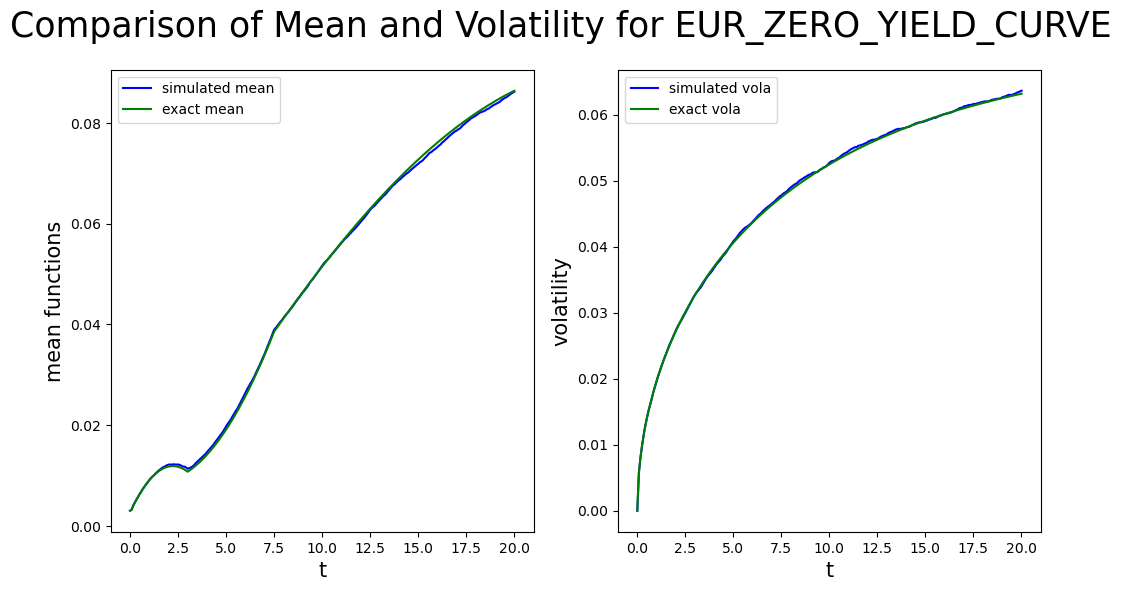

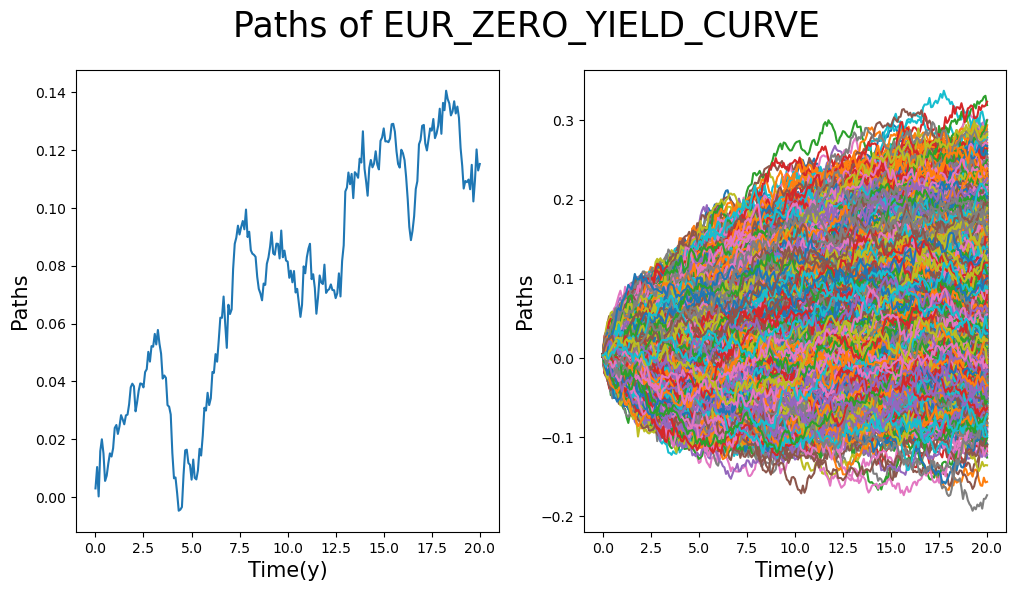

In [92]:
from data.configuration.global_parameters import calibration_parameters
calibration_parameters['RFE_HW1F_calibration']['EUR_ZERO_YIELD_CURVE'] = {'calibration_method': 'direct_input'}
S_HW1F = HW1F('EUR_ZERO_YIELD_CURVE')
RFE_dependencies=S_HW1F.get_dependencies(calibration_parameters)
market_data=MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)
S_HW1F.calibrate(market_data=market_data, calibration_parameters=calibration_parameters)
print('-----------------------------')
print(S_HW1F)
print('-----------------------------')
print(market_data)
print('-----------------------------')
paths = simulate_single_risk_factor(S_HW1F, simulation_dates, nr_paths)
test_rfe_mean_and_vola(paths, simulation_dates, S_HW1F)
plot_rfe_paths(paths, simulation_dates, S_HW1F.name)

### ii) Setting up the MultiRiskFactor object with the related dependencies and correlation matrix and generating MultiRiskFactor scenarios

In [94]:
from data.configuration.global_parameters import calibration_parameters
#Simulated RFs objects
calibration_parameters['RFE_GBM_calibration'] = {'EUR_USD_FX_RATE': {'calibration_method': 'direct_input'}}
simulated_risk_factors = set(['USD_ZERO_YIELD_CURVE','EUR_ZERO_YIELD_CURVE','EUR_USD_FX_RATE'])
simulated_risk_factor_objects = MarketDataBuilder().get_risk_factors(simulated_risk_factors, global_parameters)

#Construction of the RFs market data
RFE_dependencies=set()
for RF in simulated_risk_factors:
    model=simulated_risk_factor_objects[RF].model
    RFE_dependencies.update(model.get_dependencies(calibration_parameters))

market_data=MarketDataBuilder().load_market_data(RFE_dependencies, global_parameters)

#Calibration of the RFs models 
_ = [rf.model.calibrate(market_data, calibration_parameters) for rf in simulated_risk_factor_objects.values()]

#Load the correlation matrix
correlation_matrix = CorrelationMatrix(file_path = global_parameters['prototype_data_paths']['RFE'] + \
                                       global_parameters['prototype_data_files']['RFE']['RFE_correlation_matrix'])

scenario_object = MultiRiskFactorSimulation(simulated_risk_factor_objects.values(), correlation_matrix)
simulated_scenarios=scenario_object.generate_scenarios(simulation_dates, global_parameters)

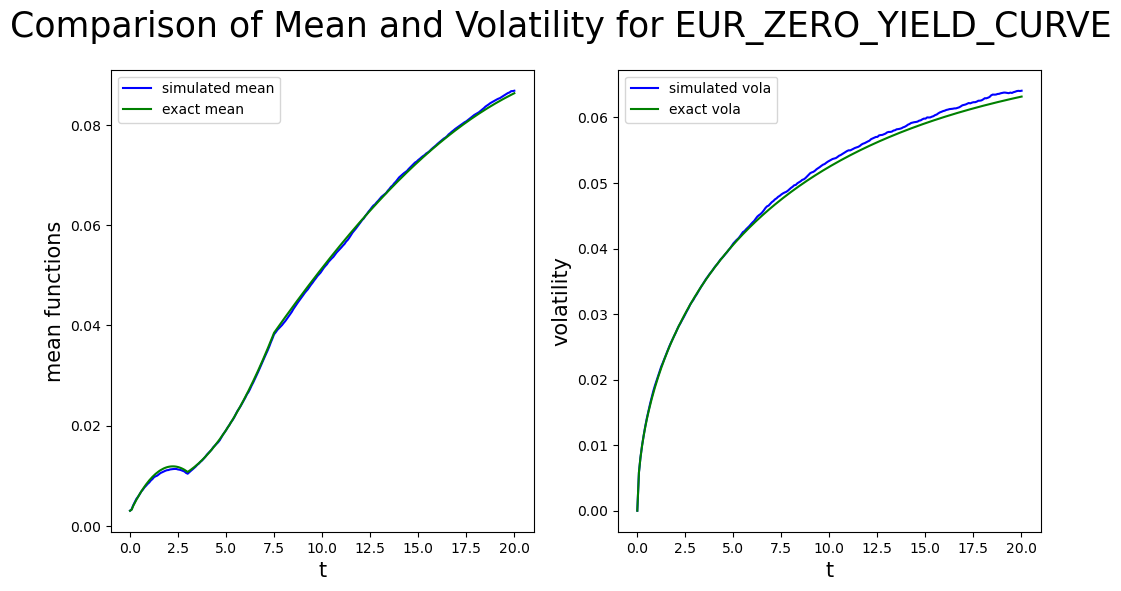

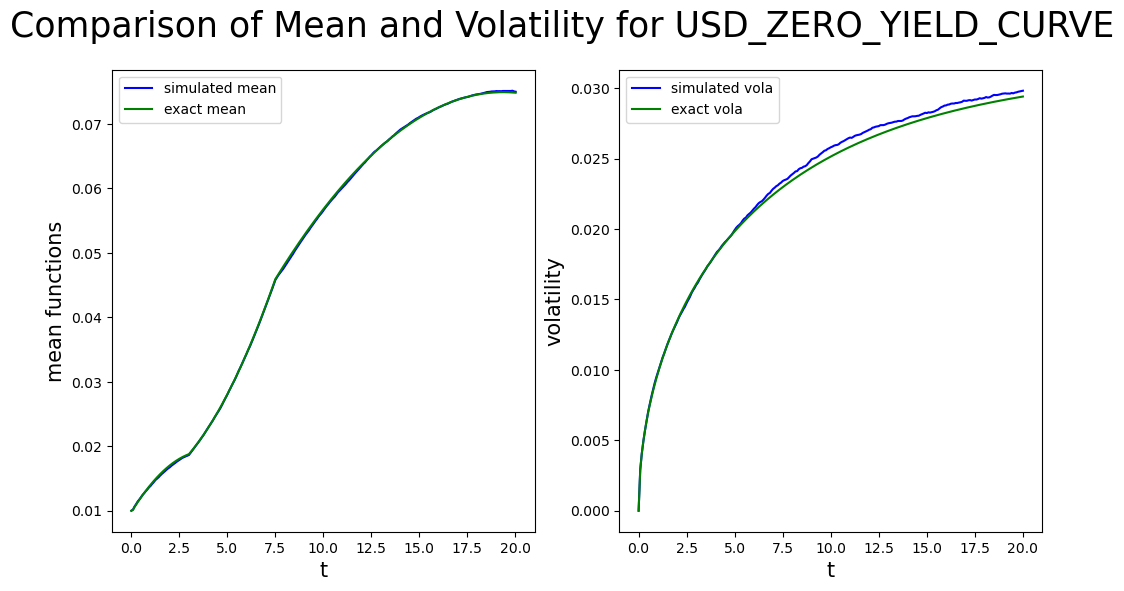

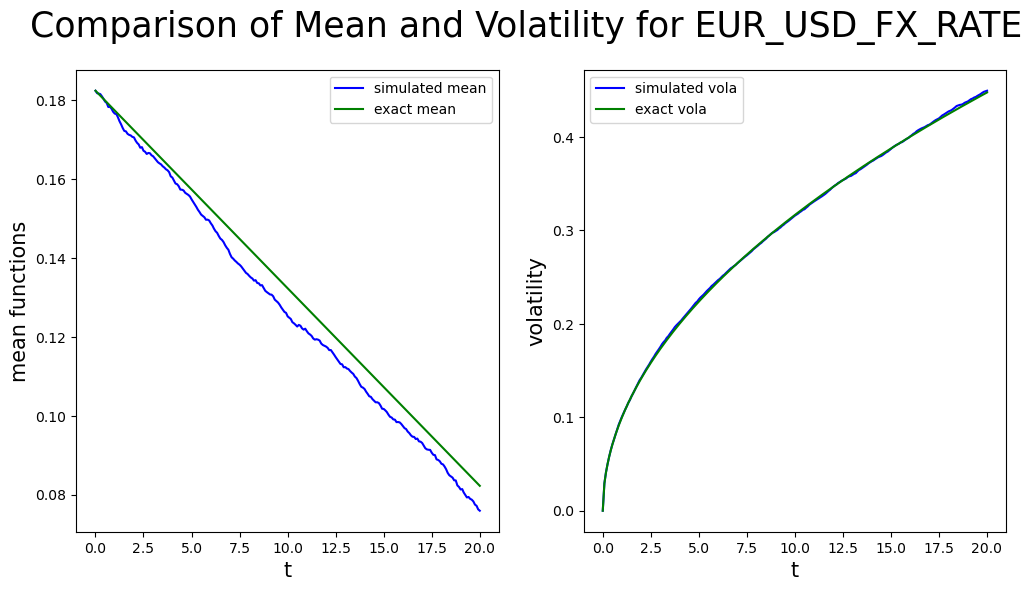

In [96]:
test_scenarios_marginal_distributions(simulated_scenarios, scenario_object)
correlations, max_error = test_scenarios_correlations(simulated_scenarios, scenario_object, correlation_matrix)

## Task 2

In [97]:
import sys
sys.path.append('..')

import numpy as np
import pandas as pd
from pimpa.trade_models.portfolio import Portfolio
from pimpa.evaluators.ccr_valuation_session import CCR_Valuation_Session
from data.configuration.global_parameters import global_parameters
from pimpa.utils.calendar_utils import transform_dates_to_time_differences

from pimpa.pricing_models.interest_rate_swap_pricer import InterestRateSwapPricer
from pimpa.pricing_models.equity_european_option_pricer import EquityEuropeanOptionPricer
from pimpa.trade_models.interest_rate_swap import InterestRateSwap
from pimpa.trade_models.equity_european_option import EquityEuropeanOption
from pimpa.market_data_objects.market_data_builder import MarketDataBuilder
from pimpa.utils.calendar_utils import generate_simulation_dates_schedule

from data.configuration.global_parameters import global_parameters, calibration_parameters


### i) Loading the trade and checking if it has the correct properties

In [100]:
trade_id = 3234
risk_factors = pd.read_csv(global_parameters['prototype_data_paths']['RFs_attributes'] + global_parameters['prototype_data_files']['RFs_attributes']['all_RFs_mapping'])
trade = InterestRateSwap(trade_id)
trade.load(global_parameters, risk_factors)
print('-----------------------------')
print(trade)
print('-----------------------------')

-----------------------------
Trade with trade_id: 3234
- trade type: IRS
- asset class: IR
- trade currency: EUR
- trade underlyings: ['EUR_LIBOR_3M_CURVE', 'EUR_ZERO_YIELD_CURVE']
- trade attributes keys: ['notional', 'currency', 'floating_rate', 'K', 'payer/receiver', 'first_fixing_date', 'last_fixing_date', 'first_payment_date', 'last_payment_date', 'payments_frequency', 'maturity', 'fixings_schedule', 'payments_schedule'])
- with 41 valuation points.
AVAILABLE
-----------------------------


### ii) Setting up the pricer

In [102]:
pricer = InterestRateSwapPricer('IRS_Pricer')
risk_factor_objects = MarketDataBuilder().get_risk_factors(trade.trade_underlyings, global_parameters)
print('-----------------------------')
print(risk_factor_objects)
print('-----------------------------')
pricer_dependencies = pricer.get_market_dependencies(trade.trade_underlyings, risk_factor_objects,calibration_parameters)
print(pricer_dependencies)
print('-----------------------------')

-----------------------------
{'EUR_ZERO_YIELD_CURVE': RiskFactor(name='EUR_ZERO_YIELD_CURVE', asset_class='IR', asset_type='DISCOUNT_CURVE', currency='EUR', simulated=True, model=<pimpa.scenario_generation.hw1f.HW1F object at 0x000002A0000BA8D0>, model_name='HW1F', reference=None), 'EUR_LIBOR_3M_CURVE': RiskFactor(name='EUR_LIBOR_3M_CURVE', asset_class='IR', asset_type='SPREAD_TO_DISCOUNT_CURVE', currency='EUR', simulated=False, model=None, model_name='NOT_AVAILABLE', reference='EUR_ZERO_YIELD_CURVE')}
-----------------------------
{('historical_fixings', 'EUR_ZERO_YIELD_CURVE'), ('historical_fixings', 'EUR_LIBOR_3M_CURVE'), ('Pricing_HW1F_calibration', 'EUR_ZERO_YIELD_CURVE'), ('spread_to_discount_curve', 'EUR_LIBOR_3M_CURVE')}
-----------------------------


### ii) Loading market data and calibrating the pricer

In [104]:
market_data = MarketDataBuilder().load_market_data(pricer_dependencies, global_parameters)
pricer.calibrate(market_data, calibration_parameters)

### ii) Pricing and plotting average MTM over time

In [106]:
trade_mtms = pricer.price_single_trade(trade, simulation_dates, simulated_scenarios, market_data, global_parameters)

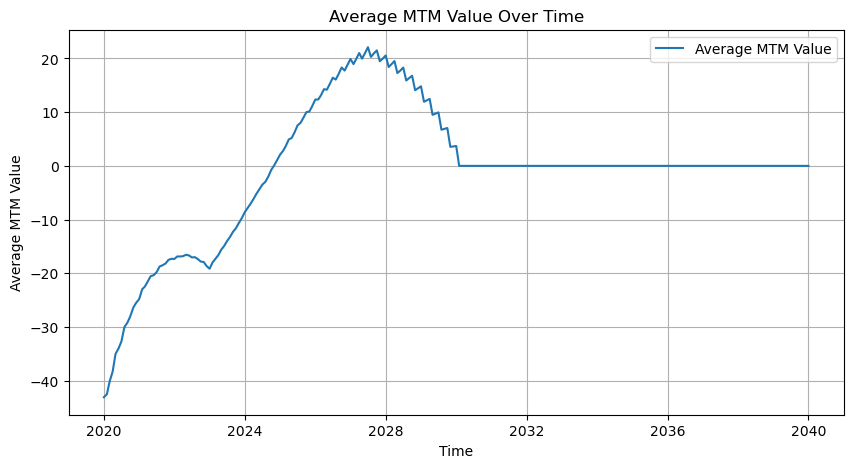

In [108]:
import matplotlib.pyplot as plt
mean_over_time = np.mean(trade_mtms, axis=0)

# Plot the average over time
plt.figure(figsize=(10, 5))
plt.plot(simulation_dates, mean_over_time, label='Average MTM Value')
plt.xlabel('Time')
plt.ylabel('Average MTM Value')
plt.title('Average MTM Value Over Time')
plt.legend()
plt.grid()
plt.show()

## Task 3

In [110]:
import sys
sys.path.append('..')

import numpy as np
from pimpa.trade_models.portfolio import Portfolio
from pimpa.evaluators.ccr_valuation_session import CCR_Valuation_Session
from data.configuration.global_parameters import global_parameters
from pimpa.utils.calendar_utils import transform_dates_to_time_differences

### i) Loading the portfolio and checking if it has the correct properties

In [120]:
netting_agreement_id = 27

portfolio_1 = Portfolio(netting_agreement_id)
portfolio_1.load(global_parameters)
print('-----------------------------')
print('Portfolio underlyings:')
for rf in portfolio_1.portfolio_underlyings:
    print(rf)
print('-----------------------------')
print('Portfolio trades:')
for _, trade in portfolio_1.trade_inventory.items():
    print(trade)
portfolio_1_run = CCR_Valuation_Session(portfolio_1)
today_date = '2019-10-10'
portfolio_1_run.run(today_date, global_parameters, pe_quantiles=[0.95], mpor_d=28)

portfolio_1_exposures = portfolio_1_run.get_exposures()
print('-----------------------------')
print(portfolio_1_exposures)
print('-----------------------------')

-----------------------------
Portfolio underlyings:
EUR_LIBOR_3M_CURVE
EUR_ZERO_YIELD_CURVE
USD_LIBOR_3M_CURVE
USD_ZERO_YIELD_CURVE
EUR_USD_FX_RATE
-----------------------------
Portfolio trades:
Trade with trade_id: 3234
- trade type: IRS
- asset class: IR
- trade currency: EUR
- trade underlyings: ['EUR_LIBOR_3M_CURVE', 'EUR_ZERO_YIELD_CURVE']
- trade attributes keys: ['notional', 'currency', 'floating_rate', 'K', 'payer/receiver', 'first_fixing_date', 'last_fixing_date', 'first_payment_date', 'last_payment_date', 'payments_frequency', 'maturity', 'fixings_schedule', 'payments_schedule'])
- with 41 valuation points.
AVAILABLE
Trade with trade_id: 3235
- trade type: IRS
- asset class: IR
- trade currency: USD
- trade underlyings: ['USD_LIBOR_3M_CURVE', 'USD_ZERO_YIELD_CURVE']
- trade attributes keys: ['notional', 'currency', 'floating_rate', 'K', 'payer/receiver', 'first_fixing_date', 'last_fixing_date', 'first_payment_date', 'last_payment_date', 'payments_frequency', 'maturity', 'fi

### ii) Plotting the relevant statistics

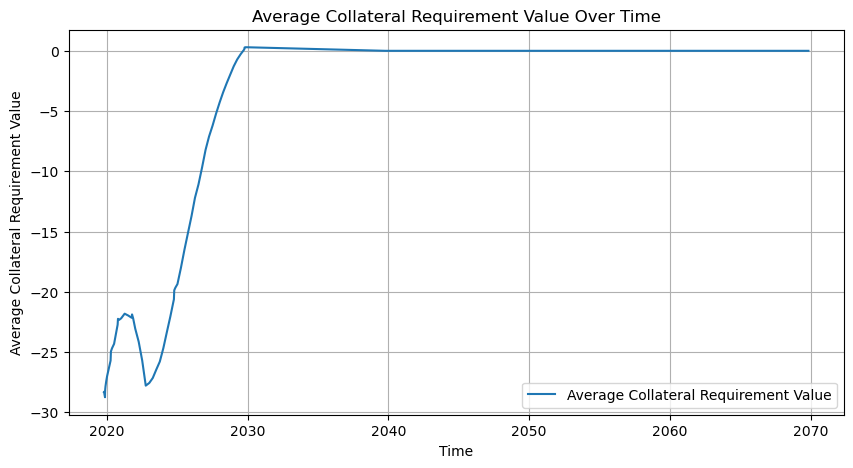

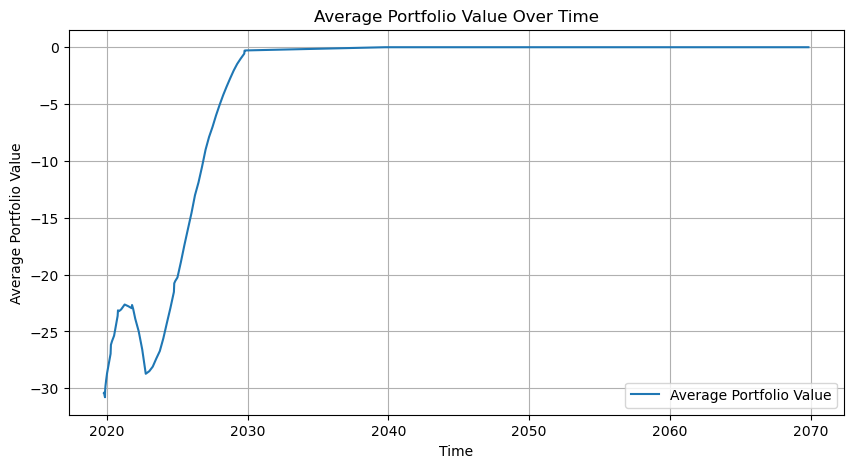

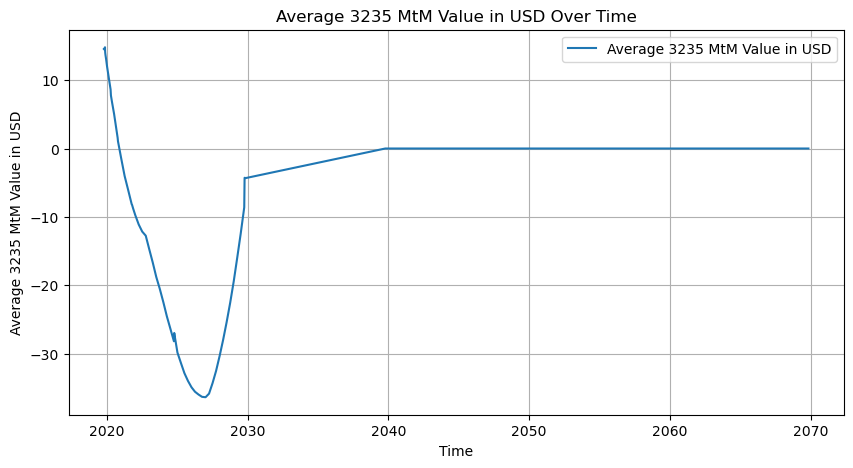

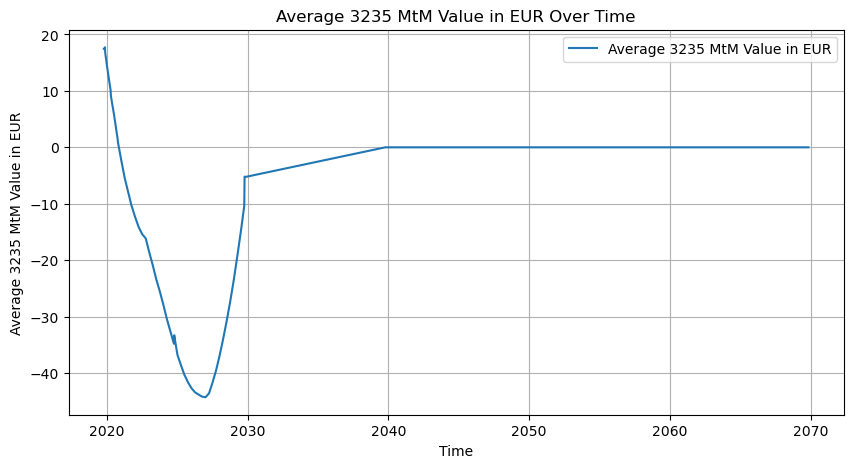

In [122]:
mean_coll_over_time = np.mean(portfolio_1_run.scenarios_collateral_requirements, axis=0)

# Plot the average over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_1_run.simulation_dates, mean_coll_over_time, label='Average Collateral Requirement Value')
plt.xlabel('Time')
plt.ylabel('Average Collateral Requirement Value')
plt.title('Average Collateral Requirement Value Over Time')
plt.legend()
plt.grid()
plt.show()

mean_coll_over_time = np.mean(portfolio_1_run.scenarios_portfolio_values, axis=0)

# Plot the average over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_1_run.simulation_dates, mean_coll_over_time, label='Average Portfolio Value')
plt.xlabel('Time')
plt.ylabel('Average Portfolio Value')
plt.title('Average Portfolio Value Over Time')
plt.legend()
plt.grid()
plt.show()

mean_coll_over_time = np.mean(portfolio_1_run.scenarios_MtMs[3235], axis=0)

# Plot the average over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_1_run.simulation_dates, mean_coll_over_time, label='Average 3235 MtM Value in USD')
plt.xlabel('Time')
plt.ylabel('Average 3235 MtM Value in USD')
plt.title('Average 3235 MtM Value in USD Over Time')
plt.legend()
plt.grid()
plt.show()

mean_coll_over_time = np.mean((portfolio_1_run.scenarios['EUR_USD_FX_RATE'])*portfolio_1_run.scenarios_MtMs[3235], axis=0)
# Plot the average over time
plt.figure(figsize=(10, 5))
plt.plot(portfolio_1_run.simulation_dates, mean_coll_over_time, label='Average 3235 MtM Value in EUR')
plt.xlabel('Time')
plt.ylabel('Average 3235 MtM Value in EUR')
plt.title('Average 3235 MtM Value in EUR Over Time')
plt.legend()
plt.grid()
plt.show()